# Introduction

### Problem

In the project this week, we will build a machine learning text classifier to predict news categories from the news article text. 

1. We will iterate on classification models with increasing level of complexity and improved performance: N-gram models, pre-trained Transformer models, and third-party hosted Large Language Models (LLMs).

2. We will look at the impact of labeled dataset size and composition on model performance. The labeled dataset will be used for training in case of N-gram models and pre-trained Transformers, and for selecting examples for in-context few-shot learning for LLMs.

3. [advanced] As an extension, we will explore how to augment data efficiently to your existing training data (efficiency measured as improvement in performance normalized by volume of data augmented). 

Throughout the project there are suggested model architectures that we expect to work reasonably well for this problem. But if you wish to extend/modify any part of this pipeline, or explore new model architectures you should definitely feel free to do so.


## Step1: Prereqs & Installation

Download & Import all the necessary libraries we need throughout the project.

In [1]:
# Install all the required dependencies for the project

!pip install numpy
!pip install scikit-learn
!pip install sentence-transformers
!pip install matplotlib
!pip install langchain
!pip install openai
!pip install numba
!pip install umap-learn
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=2d4558c4f21b53a27d9c72090a87258f4f601ab97a2d50c6d07dfe1d5988b03b
  St

In [2]:
import os
os.environ["OPENAI_API_KEY"] = "api_key"

In [3]:
# Package imports that will be needed for this project

import numpy as np
import json
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# [TO BE IMPLEMENTED] 
# Add any other imports needed below depending on the model architectures you are using. For e.g.
# from sklearn.linear_model import LogisticRegression

import umap
from catboost import CatBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [8]:
# Global Constants
LABEL_SET = [
    'Business',
    'Sci/Tech',
    'Software and Developement',
    'Entertainment',
    'Sports',
    'Health',
    'Toons',
    'Music Feeds'
]

SENTENCE_TRANSFORMER_MODEL = 'all-MiniLM-L6-v2' #'all-mpnet-base-v2'

TRAIN_SIZE_EVALS = [500, 1000, 10000, 25000]
EPS = 0.001
SEED = 0

np.random.seed(SEED)

## Step 2: Download & Load Datasets 

[AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) is a collection of more than 1 million news articles gathered from more than 2000 news sources by an academic news search engine. The news topic classification dataset & benchmark was first used in [Character-level Convolutional Networks for Text Classification (NIPS 2015)](https://arxiv.org/abs/1509.01626). The dataset has the text description (summary) of the news article along with some metadata. **For this project, we will use a slightly modified (cleaned up) version of this dataset** 

Schema:
* Source - News publication source
* URL - URL of the news article
* Title - Title of the news article
* Description - Summary description of the news article
* Category (Label) - News category

Sample row in this dataset:
```
{
    'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
    'id': 86273,
    'label': 'Entertainment',
    'source': 'Voice of America',
    'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
    'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'
 }
```




In [9]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

DIRECTORY_NAME = "data"
DOWNLOAD_URL = 'https://corise-mlops.s3.us-west-2.amazonaws.com/project1/agnews.zip'

def download_dataset():
    """
    Download the dataset. The zip contains three files: train.json, test.json and unlabeled.json 
    """
    http_response = urlopen(DOWNLOAD_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DIRECTORY_NAME)

# Expensive operation so we should just do this once
download_dataset()

In [10]:
Datasets = {}

for ds in ['train', 'test_mini', 'augment']:
    with open('data/{}.json'.format(ds), 'r') as f:
        if ds == 'test_mini':
          Datasets['test'] = json.load(f)
        else:
          Datasets[ds] = json.load(f)
    print("Loaded Dataset {0}".format(ds))

print("\nExample train row:\n")
pprint(Datasets['train'][0])

print("\nExample test row:\n")
pprint(Datasets['test'][0])

Loaded Dataset train
Loaded Dataset test_mini
Loaded Dataset augment

Example train row:

{'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
 'id': 86273,
 'label': 'Entertainment',
 'source': 'Voice of America',
 'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
 'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'}

Example test row:

{'description': "AP - Denny Neagle's contract was terminated by the Colorado "
                'Rockies on Monday, three days after the oft-injured pitcher '
                'was cited for solicitation.',
 'id': 116767,
 'label': 'Sports',
 'source': 'Yahoo Sports',
 'title': "Rockies Terminate Neagle's Contract (AP)",
 'url': 'http://us.rd.yahoo.com/dailynews/rss/sports/*http://story.news.yahoo.com/news?tmpl=story2 '
        'u=/ap/20041207/ap_on_sp_ba_ne/bbn_rocki

In [11]:
X_train, Y_train = [], []
X_test, Y_true = [], []
X_augment, Y_augment = [], []

for row in Datasets['train']:
    X_train.append(row['description'])
    Y_train.append(row['label'])

for row in Datasets['test']:
    X_test.append(row['description'])
    Y_true.append(row['label'])

for row in Datasets['augment']:
    X_augment.append(row['description'])
    Y_augment.append(row['label'])

## Step 3: [Modeling part 1] N-gram model

---




In [12]:
models = {}

for n in TRAIN_SIZE_EVALS:
    print("Evaluating for training data size = {}".format(n))
    X_train_i = X_train[:n]
    Y_train_i = Y_train[:n]

    """
    [TO BE IMPLEMENTED]
        
    Goal: initialized below is a dummy sklearn Pipeline object with no steps.
    You have to replace it with a pipeline object which contains at least two steps:
    (1) mapping the input document to an N-gram feature extractor. You can use feature extractors
        provided by sklearn out of the box (e.g. CountVectorizer, TfidfTransformer)
    (2) a classifier that predicts the class label using the feature output of first step

    You can add other steps to preproces, post-process your data as you see fit. 
    You can also try any sklearn model architecture you want, but a linear classifier
    will do just fine to start with

    e.g. 
    pipeline = Pipeline([
        ('featurizer', <your N-gram featurizer class instance here>),
        ('classifier', <your sklearn classifier class instance here>)
    ])

    Reference: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    """

    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([
         ('featurizer1', CountVectorizer()),
         ('featurizer2', TfidfTransformer()),
         ('clf', CatBoostClassifier(iterations=1000, task_type="GPU", devices='0', verbose = 500)),
         ])
    
    # train
    pipeline.fit(X_train_i, Y_train_i)
    # predict
    Y_pred_i = pipeline.predict(X_test)
    # record results
    models[n] = {
        'pipeline': pipeline,
        'test_predictions': Y_pred_i,
        'accuracy': accuracy_score(Y_true, Y_pred_i),
        'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
        'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
    }
    print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))

Evaluating for training data size = 500
Learning rate set to 0.056347
0:	learn: 2.0291398	total: 11.4ms	remaining: 11.4s
500:	learn: 0.6853652	total: 3.41s	remaining: 3.4s
999:	learn: 0.4688531	total: 6.61s	remaining: 0us
Accuracy on test set: 0.562
Evaluating for training data size = 1000
Learning rate set to 0.064906
0:	learn: 2.0220326	total: 40.4ms	remaining: 40.4s
500:	learn: 0.7523120	total: 6.78s	remaining: 6.75s
999:	learn: 0.5606701	total: 10.7s	remaining: 0us
Accuracy on test set: 0.57
Evaluating for training data size = 10000
Learning rate set to 0.103821
0:	learn: 1.9592260	total: 78.4ms	remaining: 1m 18s
500:	learn: 0.7811843	total: 13.9s	remaining: 13.8s
999:	learn: 0.6977091	total: 27s	remaining: 0us
Accuracy on test set: 0.722
Evaluating for training data size = 25000
Learning rate set to 0.125159
0:	learn: 1.9354902	total: 73.3ms	remaining: 1m 13s
500:	learn: 0.7604072	total: 24.4s	remaining: 24.3s
999:	learn: 0.6989665	total: 47s	remaining: 0us
Accuracy on test set: 0

## Step 4: [Modeling part 2] Pretrained Transformer model

In [13]:
# Initialize the pretrained transformer model
sentence_transformer_model = SentenceTransformer(
    'sentence-transformers/{model}'.format(model=SENTENCE_TRANSFORMER_MODEL),
    device = 'cuda')

# Sanity check
example_encoding = sentence_transformer_model.encode(["This is an example sentence","This is another example of a sentence"],
                                                     normalize_embeddings=True)

print(example_encoding)

[[ 6.76568523e-02  6.34959340e-02  4.87131067e-02  7.93049783e-02
   3.74480896e-02  2.65277643e-03  3.93749699e-02 -7.09845778e-03
   5.93613833e-02  3.15369777e-02  6.00980707e-02 -5.29051535e-02
   4.06067707e-02 -2.59308480e-02  2.98428368e-02  1.12691533e-03
   7.35148713e-02 -5.03819250e-02 -1.22386597e-01  2.37028506e-02
   2.97265183e-02  4.24768850e-02  2.56337859e-02  1.99516281e-03
  -5.69190495e-02 -2.71597914e-02 -3.29035483e-02  6.60248548e-02
   1.19007118e-01 -4.58791330e-02 -7.26214871e-02 -3.25840153e-02
   5.23413643e-02  4.50552851e-02  8.25298019e-03  3.67024206e-02
  -1.39414957e-02  6.53918907e-02 -2.64272615e-02  2.06405472e-04
  -1.36643117e-02 -3.62810157e-02 -1.95043497e-02 -2.89738290e-02
   3.94270495e-02 -8.84090886e-02  2.62424652e-03  1.36713898e-02
   4.83062603e-02 -3.11565865e-02 -1.17329188e-01 -5.11690229e-02
  -8.85287598e-02 -2.18962487e-02  1.42986365e-02  4.44168039e-02
  -1.34815406e-02  7.43392557e-02  2.66382769e-02 -1.98762324e-02
   1.79191

In [14]:
class TransformerFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, sentence_transformer_model):
        #self.dim = dim
        self.sentence_transformer_model = sentence_transformer_model
        # you can add any other params to be passed to the constructor here

    #estimator. Since we don't have to learn anything in the featurizer, this is a no-op
    def fit(self, X, y=None):
        return self

    #transformation: return the encoding of the document as returned by the transformer model 
    def transform(self, X, y=None):
        #X_t = []
        """
        [TO BE IMPLEMENTED]
        
        Goal: TransformerFeaturizer's transform() method converts the raw text document
        into a feature vector to be passed as input to the classifier.
            
        Given below is a dummy implementation that always maps it to a zero vector.
        You have to implement this function so it uses computes a document embedding
        of the input document using self.sentence_transformer_model. 
        This will be our feature representation of the document
        """

        X_t = self.sentence_transformer_model.encode(X)
        #for doc in X:
            # TODO: replace this dummy implementation
        #    X_t.append(np.zeros(self.dim))
        return X_t

In [15]:
models_v2 = {}
for n in TRAIN_SIZE_EVALS:
    print("Evaluating for training data size = {}".format(n))
    X_train_i = X_train[:n]
    Y_train_i = Y_train[:n]

    """
    [TO BE IMPLEMENTED]
        
    Goal: initialized below is a dummy sklearn Pipeline object with no steps.
    You have to replace it with a pipeline object which contains at least two steps:
    (1) mapping the input document to a feature vector (using TransformerFeaturizer)
    (2) a classifier that predicts the class label using the feature output of first step

    You can add other steps to preproces, post-process your data as you see fit. 
    You can also try any sklearn model architecture you want, but a linear classifier
    will do just fine to start with

    e.g. 
    pipeline = Pipeline([
        ('featurizer', <your TransformerFeaturizer class instance here>),
        ('classifier', <your sklearn classifier class instance here>)
    ])
    """
    sentence_transformer = SentenceTransformer(f'sentence-transformers/{SENTENCE_TRANSFORMER_MODEL}',device = 'cuda')
    pipeline = Pipeline([('featurizer', TransformerFeaturizer(sentence_transformer)),
                        ('classifier', CatBoostClassifier(iterations=1000, task_type="GPU", devices='0', verbose = 500))
                        ])

    # train
    pipeline.fit(X_train_i, Y_train_i)
    # predict
    Y_pred_i = pipeline.predict(X_test)
    # record results
    models_v2[n] = {
        'pipeline': pipeline,
        'test_predictions': Y_pred_i,
        'accuracy': accuracy_score(Y_true, Y_pred_i),
        'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
        'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
    }
    print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))


Evaluating for training data size = 500
Learning rate set to 0.056347
0:	learn: 2.0391642	total: 11.1ms	remaining: 11.1s
500:	learn: 0.1006615	total: 7.68s	remaining: 7.65s
999:	learn: 0.0514235	total: 11.5s	remaining: 0us
Accuracy on test set: 0.671
Evaluating for training data size = 1000
Learning rate set to 0.064906
0:	learn: 2.0177134	total: 11.3ms	remaining: 11.3s
500:	learn: 0.1173601	total: 7.12s	remaining: 7.09s
999:	learn: 0.0629467	total: 11.6s	remaining: 0us
Accuracy on test set: 0.701
Evaluating for training data size = 10000
Learning rate set to 0.103821
0:	learn: 1.9095572	total: 11.7ms	remaining: 11.7s
500:	learn: 0.2861987	total: 8.23s	remaining: 8.2s
999:	learn: 0.1719222	total: 12.6s	remaining: 0us
Accuracy on test set: 0.739
Evaluating for training data size = 25000
Learning rate set to 0.125159
0:	learn: 1.8669347	total: 12.5ms	remaining: 12.5s
500:	learn: 0.3684709	total: 5.75s	remaining: 5.73s
999:	learn: 0.2505654	total: 13s	remaining: 0us
Accuracy on test set: 

## Step 5: [Modeling part 3] Large Language Models

In [16]:
# Here's a couple of code snippets to help you familiarize with how to generate labels with LLMs using langchain,

from langchain.chat_models import ChatOpenAI
from langchain.schema import LLMResult, HumanMessage, Generation

llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    max_tokens=1000,
    temperature=0.0
)

In [17]:

zero_shot_prompt_template = """
You are an expert at judging the sentiment of tweets. 
Your job is to categorize the sentiment of a given tweet into one of three categories: Positive, Negative, Neutral.

Tweet: {tweet}
Sentiment:
"""

prompt = zero_shot_prompt_template.format(
    tweet="Yesss! I love machine learning"
)

result = llm.generate([[HumanMessage(content=prompt)]])
print(result.generations[0][0])


text='Positive' generation_info=None message=AIMessage(content='Positive', additional_kwargs={}, example=False)


In [35]:

few_shot_prompt_template = """
You are an expert at judging the sentiment of tweets. 
Your job is to categorize the sentiment of a given tweet into one of three categories: Positive, Negative, Neutral.

Some example tweets along with the correct sentiment are shown below.

Tweet: Another big happy 18th birthday to my partner in crime. I love u very much!
Sentiment: Positive

Tweet: The more I use this application, the more I dislike it. It's slow and full of bugs.
Sentiment: Negative

Tweet: #Dreamforce Returns to San Francisco for 20th Anniversary. Learn more: http://bit.ly/3AgwO0H
Sentiment: Neutral

Now I want you to label the following example (provide the answer only with the word corresponding to the sentiment): 
Tweet: {tweet}
Sentiment:
"""

prompt = few_shot_prompt_template.format(
    tweet="I like chocolate"
)

result = llm.generate([[HumanMessage(content=prompt)]])
print(result.generations[0][0])

text='Positive' generation_info=None message=AIMessage(content='Positive', additional_kwargs={}, example=False)


In [24]:
from sklearn.base import BaseEstimator, ClassifierMixin
import time



class LLMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, llm_model, prompt_template):
        self.llm_model = llm_model
        self.prompt_template = prompt_template

    #This will be called during the training step
    def fit(self, X, y):
        return self

    #This will be called during inference.
    def predict(self, X):
        """
        [TO BE IMPLEMENTED]
        
        Goal: LLMClassifier's predict() method constructs the final prompt input
        for the LLM for each x in X, using the prompt template.

        You have to implement this function so it does the following:
        1. Construct the final prompt for the LLM
        2. Call `self.llm_model` to generate the completion (label) for the prompt
        3. Do any post-processing/response parsing to fetch the label from the LLM response
        """
        Y = []
        for i,x in enumerate(X):
          prompt = self.prompt_template.format(input_text = x)
          result = self.llm_model.generate([[HumanMessage(content=prompt)]])
          y = result.generations[0][0].text
          Y.append(y)
          if i%10 == 0:
            print(f"obs number: {i}")

        return Y

In [27]:
# Zero-shot classification pipeline with LLMs

models_v3 = {}

"""
[TO BE IMPLEMENTED]
        
Goal: initialized below is a dummy sklearn Pipeline object with no steps.
You have to replace it with a pipeline object which uses the `LLMClassifier` you have implemented 
above to perform zero-shot classification on the test set.

You can add other steps to preproces, post-process your data as you see fit. 

"""
prompt_template = """
What is the main topic of the following news summary, which is delimited with triple backticks?
The only possible answers are in the list called "LABEL_SET" given as follows:
LABEL_SET = ['Business','Sci/Tech','Software and Developement','Entertainment','Sports','Health','Toons','Music Feeds']
Give your answer as a single word from the LABEL_SET list.

News summary: '''{input_text}'''
"""
pipeline = Pipeline([('llm_zs_classifier', LLMClassifier(llm_model=llm, prompt_template=prompt_template))])

# train
pipeline.fit(X_train_i, Y_train_i)
# predict
Y_pred_i = pipeline.predict(X_test[:10])
# record results
models_v3["zero-shot"] = {
    'test_predictions': Y_pred_i,
    'accuracy': accuracy_score(Y_true[:10], Y_pred_i),
    'f1': f1_score(Y_true[:10], Y_pred_i, average='weighted'),
    'errors': sum([x != y for (x, y) in zip(Y_true[:10], Y_pred_i)])
}
print("Accuracy on test set: {}".format(accuracy_score(Y_true[:10], Y_pred_i)))

Accuracy on test set: 0.7


In [ ]:
# Few-shot classification with LLMs

"""
[TO BE IMPLEMENTED]
        
Goal: initialized below is a dummy sklearn Pipeline object with no steps.
You have to replace it with a pipeline object which uses the `LLMClassifier` you have implemented 
above to perform few-shot classification on the test set.

With few-shot classification, you can pass upto 5 demonstration examples as part of the prompt 
to the LLM. You can add other steps to preproces, post-process your data as you see fit. 

"""
pipeline = Pipeline()

# train
pipeline.fit(X_train_i, Y_train_i)
# predict
Y_pred_i = pipeline.predict(X_test)
# record results
models_v3["few-shot"] = {
    'test_predictions': Y_pred_i,
    'accuracy': accuracy_score(Y_true, Y_pred_i),
    'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
    'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
}
print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))


## Step 5: Report Results from previous two steps

In [28]:
# Report results

print("N-gram Models: ")
for train_size, result in models.items():
    print("Train size: {0}  |  Accuracy: {1}  |  F1 score: {2} |  Num errors: {3}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))


N-gram Models: 
Train size: 500  |  Accuracy: 0.562  |  F1 score: 0.5547484396332822 |  Num errors: [438]
Train size: 1000  |  Accuracy: 0.57  |  F1 score: 0.5646729033856493 |  Num errors: [430]
Train size: 10000  |  Accuracy: 0.722  |  F1 score: 0.7180259813311332 |  Num errors: [278]
Train size: 25000  |  Accuracy: 0.738  |  F1 score: 0.734743417796069 |  Num errors: [262]


In [29]:
print("Pretrained Transformer Models: ")
for train_size, result in models_v2.items():
    print("Train size: {0}  |  Accuracy: {1}  |  F1 score: {2} |  Num errors: {3}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

Pretrained Transformer Models: 
Train size: 500  |  Accuracy: 0.671  |  F1 score: 0.6596450421149866 |  Num errors: [329]
Train size: 1000  |  Accuracy: 0.701  |  F1 score: 0.6941424100424571 |  Num errors: [299]
Train size: 10000  |  Accuracy: 0.739  |  F1 score: 0.7336112153151628 |  Num errors: [261]
Train size: 25000  |  Accuracy: 0.753  |  F1 score: 0.7468763331907694 |  Num errors: [247]


In [31]:
print("Large Language Models: ")
for mode, result in models_v3.items():
    print("Mode: {0}  |  Accuracy: {1}  |  F1 score: {2} |  Num errors: {3}".format(
        mode,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

Large Language Models: 
Mode: zero-shot  |  Accuracy: 0.7  |  F1 score: 0.65 |  Num errors: 3


## Step 6: Data Augmentation [Optional]

In this section, we want to explore how to augment data efficiently to your existing training data. This is a very empirical exercise with a less well-defined playbook which means this section of the project is going to be open ended. Let us first understand what we mean by efficiency here, and why it matters:

### Performance Gain (G):
We will measure performance gain from data augmentation as the improvement in model accuracy (reduction in num. errors) on the Test dataset as defined above. 

### Budget (K):
We will measure "budget" as the number of additional rows augmentated to the original training dataset.  In this project, the universe of data from which you will select to add to your training set is Datasets['augment'] (and downstream X_augment, Y_augment).

This data is already labeled of course, but in most real-world scenarios the additional data is typically unlabeled. In order to augment it to your training data, you have to get it annotated which incurs some cost in time & money. This is the motivation to consider budget as a metric.

### Efficiency (E = G / K): 
Efficiency = Performance Gain (Reduction in num errors in test set) / Budget (Number of additional rows augmented to the training dataset)

We want to get the maximum gain in performance, while incurring minimum annotation cost.



We can always sample more data at random from the augmentation set, and this is probably the first thing to try. Can we be more intelligent with the data we choose to augment to the training dataset?

**Idea 1**: Look at the test errors that the current model is making. How can this help us guide our "data collection" for augmentation? One possible idea is to select examples from the augmentation dataset that are similar to these errors and add them to the training data. Similarity can be approximated in many ways:
1. [Jaccard distance between two texts](https://studymachinelearning.com/jaccard-similarity-text-similarity-metric-in-nlp/)
2. L2 distance between mean word vectors (we already compute these features for the entire dataset using WordVectorFeaturizer)
3. L2 distance between sentence transformer embedding (we already compute these features for the entire dataset using TransformerFeaturizer)
  

**Idea 2**: Compute model's predictions on the augmentation dataset, and include those examples to the training dataset that the model finds "hard" ? (a proxy for this would be to look at cases where the output score distribution across all labels has nearly identical scores for top two or three labels).

**Idea 3**: Look at the test errors that the current model is making, and the distribution of these errors across labels. Select examples from the augmentation dataset that belong to these classes - adding more training data for labels that the curent model does not do well on, can improve performance (assuming label quality is good)

In [32]:
# Examine current test errors
test_errors = []
Y_pred_i = models[25000]['test_predictions']

for idx, label in enumerate(Y_true):
    if label != Y_pred_i[idx]:
        test_errors.append((X_test[idx], label,  Y_pred_i[idx]))

print("Number of errors in the test set: {}".format(len(test_errors)))
print("Example errors: [example, true label, predicted label]")
for i in range(10):
    print(test_errors[i])

Number of errors in the test set: 262
Example errors: [example, true label, predicted label]
('The rush by Wal-Mart and other companies to put radio frequency identification devices in their goods could imperil consumer privacy.', 'Software and Developement', array(['Business'], dtype=object))
('Intel said Thursday that President Paul Otellini will become its next CEO -- a change that could help the No. 1 chipmaker overcome recent missteps.', 'Entertainment', array(['Sci/Tech'], dtype=object))
('Thousands of Douglas County residents at high risk for influenza may be unable to get flu shots this year because of a shortage of vaccine.', 'Entertainment', array(['Health'], dtype=object))
('Jeff Greenberg leaves post at No. 1 insurance broker not long after Spitzer targeted firm: WSJ. NEW YORK (CNN/Money) - Marsh  amp; McLennan #39;s embattled Chief Executive Officer Jeffrey Greenberg stepped down as', 'Entertainment', array(['Business'], dtype=object))
('The service allows users to search 

In [ ]:
'''
[TO BE IMPLEMENTED]

Your additional data augmentation explorations go here

For instance, the pseudocode for Idea (1) might look like the following:

Augmented = {}
For e in test_errors:
   1. X_nn, y_nn = k nearest neighbors to (e) from X_augment, y_augment
   2. Add each (x, y) from (X_nn, y_nn) to Augmented

Add the Augmented examples to the training set
Train the new model and record performance improvements

'''

In [ ]:
#We will use dimensionality reduction with UMAP to a) avoid issues with dimensionality with the knn algorithm and b) to use labeled data info to find
#similar datapoints from an 'unlabeled' dataset.

#Step 1: We use the transformer featurizer and encode labels into numbers
sentence_transformer = SentenceTransformer(f'sentence-transformers/all-MiniLM-L6-v2',device = 'cuda')
xtrain_features = sentence_transformer.encode(X_train)
augment_features = sentence_transformer.encode(X_augment)
#Enode labels to numbers: 
le = LabelEncoder()
le.fit(Y_train)
numeric_labels_train = le.transform(Y_train)

#Step 3: build a supervised embedding using UMAP with the train data (features)
mapper = umap.UMAP().fit(xtrain_features, y=numeric_labels_train)
embedding = mapper.embedding_

#Step 4: produce embeddings for 'unlabeled' augment data set 
augmented_reduced = mapper.transform(augment_features)

#Step 5: Fit the knn instance to the unlabeled embeddings and look for the k=5 nearest neighboors in the (labeled) errors
nbrs = NearestNeighbors(n_neighbors=5).fit(augmented_reduced)

distances, indices = nbrs.kneighbors(test_errors)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


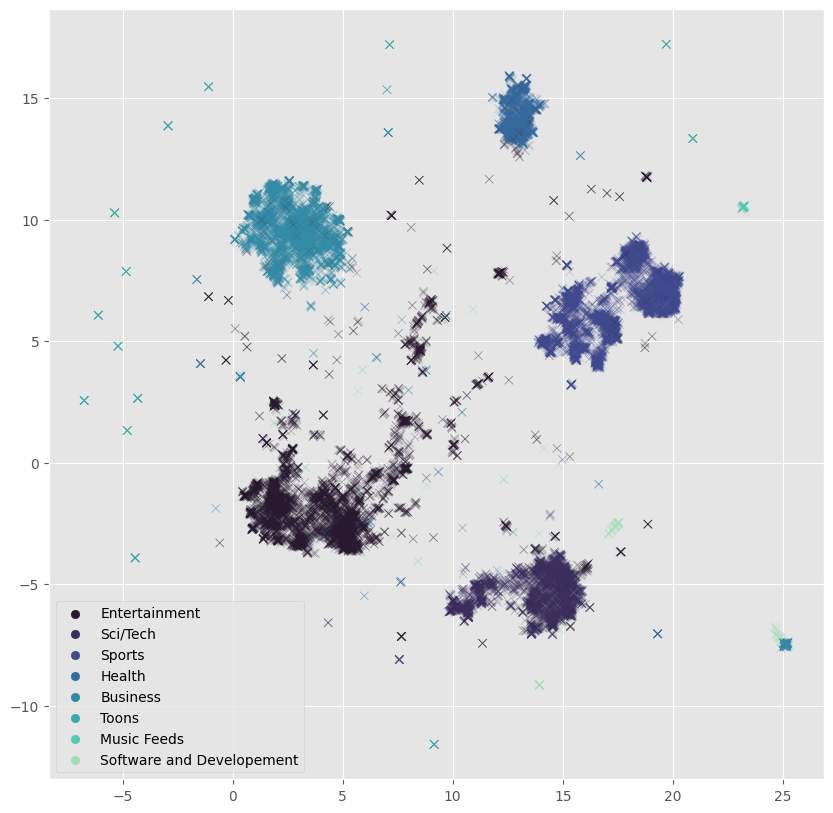

In [122]:
#Supervised low dimensional embedding
plt.figure(figsize = (10,10))
sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue = le.inverse_transform(numeric_labels_train), alpha = 0.3, marker = 'x', palette = 'mako');

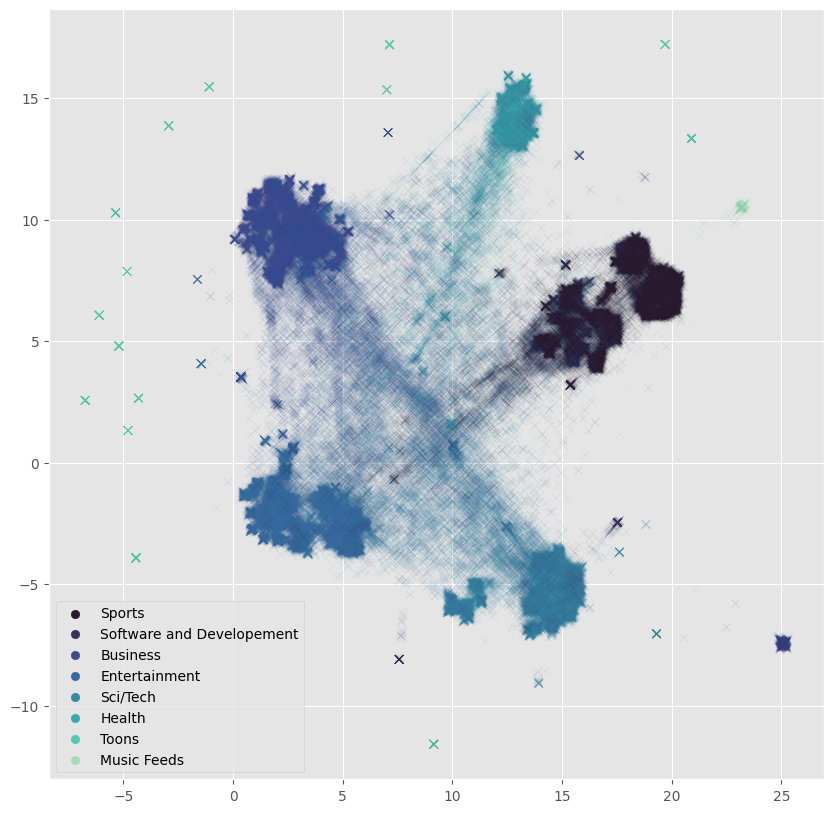

In [120]:
#Unsupervised embedding
plt.figure(figsize = (10,10))
sns.scatterplot(x = augmented_reduced[:,0], y = augmented_reduced[:,1], hue = Y_augment, alpha = 0.1, marker = 'x', palette = 'mako');